# Explore Data
    Clinical_data: contains clinical data for each sample (inside 'None')
    goodlist: tells for each pixel in the unfolded MSI_data_cube if it is a MSI spectrum or not
    HE_image: histological image for each sample
    MSI_data_cube: contains the spectral data in the z-dimension; not every pixel is associated to a MSI spectrum (see goodlist)
    peak_list: contains information about the peaks (mz value, average intensity, lower boundary, upper boundary)
    pixel_to_sample_ID: tells for each pixel in the MSI_data_cube to which sample_ID it belongs; can be linked to sample_ID of Clinical_data table
    x: width of dataset in pixels
    y: height of dataset in pixels
    z: number of peaks (z-dimension of MSI_data_cube)

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

# Load Gastric Cancer Data

In [3]:
gc_data = scipy.io.loadmat('Data/gastric_cancer_dataset.mat')
gc_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 16 17:56:56 2016',
 '__version__': '1.0',
 '__globals__': [],
 'goodlist': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'x': array([[1653]], dtype=uint16),
 'y': array([[443]], dtype=uint16),
 'z': array([[82]], dtype=uint8),
 'peak_list': array([[2.75700000e+03, 1.76690867e+01, 2.75314020e+03, 2.76085980e+03],
        [3.00600000e+03, 1.47126952e+01, 3.00179160e+03, 3.01020840e+03],
        [3.19600000e+03, 2.17044555e+01, 3.19152560e+03, 3.20047440e+03],
        [3.33000000e+03, 6.48135994e+01, 3.32533800e+03, 3.33466200e+03],
        [3.37400000e+03, 1.96713385e+02, 3.36927640e+03, 3.37872360e+03],
        [3.40900000e+03, 8.74490767e+01, 3.40422740e+03, 3.41377260e+03],
        [3.44500000e+03, 3.05325220e+02, 3.44017700e+03, 3.44982300e+03],
        [3.48200000e+03, 2.20805023e+02, 3.47712520e+03, 3.48687480e+03],
        [3.51600000e+03, 7.3793

# See Important Keys in gc_data

In [4]:
gc_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'goodlist', 'x', 'y', 'z', 'peak_list', 'MSI_data_cube', 'HE_image', 'None', 'pixel_to_sample_ID', '__function_workspace__'])

# Good list contain 2 types of pixel:
1. background Pixel (0)
2. Pixel of Protein in gc_data (1)

In [8]:
pixels = gc_data['goodlist']
print("Number/size of pixels in gc_data:", pixels.size)
print("shape of pixels in gc_data:", pixels.shape)
print(type(pixels))
# pixels_list = list(pixels)
# print(pixels_list)
# for i in range(0, len(pixels_list):
#     print("Indexes of pixels with value of 1:", )

Number/size of pixels in gc_data: 732279
shape of pixels in gc_data: (732279, 1)
<class 'numpy.ndarray'>


# Explain MSI_data_cube
> ***MSI_data_cube Contains image of each protein data in gc_data.*** <br>
> ***MSI_data_cube shape contains x, y and z which are:*** <br>
    > * x: width of dataset in pixels
    > * y: height of dataset in pixels
    > * z: number of peaks (z-dimension of MSI_data_cube)

In [16]:
MSI = gc_data['MSI_data_cube']
print("Number/size of MSI in gc_data:", MSI.size)
print("shape of MSI in gc_data:", MSI.shape)
print("Type of MSI is:", type(MSI))

Number/size of MSI in gc_data: 60046878
shape of MSI in gc_data: (443, 1653, 82)
Type of MSI is: <class 'numpy.ndarray'>


# Get m/z Values from gc_data

In [15]:
mz_val = gc_data['peak_list'][:, 0]
print(mz_val)
print("Type of mz_val is:", type(mz_val))

[ 2757.  3006.  3196.  3330.  3374.  3409.  3445.  3482.  3516.  3598.
  3670.  3711.  3908.  4051.  4128.  4156.  4192.  4621.  4748.  4788.
  4828.  4912.  4940.  4967.  5003.  5145.  5173.  5655.  5699.  6180.
  6227.  6279.  6368.  6652.  6691.  6721.  6897.  6953.  6982.  7009.
  7568.  7671.  7756.  8101.  8417.  8454.  8571.  8606.  8694.  9192.
  9268.  9335.  9414.  9467.  9521.  9752. 10099. 10319. 10843. 11315.
 11355. 11615. 11657. 11831. 12179. 12234. 12285. 12354. 13166. 13436.
 13793. 13826. 13862. 13915. 14021. 14708. 15144. 15346. 15888. 21326.
 21830. 22550.]
Type of mz_val is: <class 'numpy.ndarray'>


# Get Index of Specific Proteins m/z Values

In [14]:
mz_val_list = list(mz_val)
print("index of protein with m/z values equal to 3374 is:", mz_val_list.index(3374))
print("index of protein with m/z values equal to 3409 is:", mz_val_list.index(3409))
print("index of protein with m/z values equal to 3445 is:", mz_val_list.index(3445))
print("index of protein with m/z values equal to 4967 is:", mz_val_list.index(4967))
print("index of protein with m/z values equal to 14201 is:", mz_val_list.index(14021))

index of protein with m/z values equal to 3374 is: 4
index of protein with m/z values equal to 3409 is: 5
index of protein with m/z values equal to 3445 is: 6
index of protein with m/z values equal to 4967 is: 23
index of protein with m/z values equal to 14201 is: 74


## Visualization of protein 4 from MSI_data_cube

### Note: We can know the m/z for any specific proteins at the peak_list data

In [18]:
P4 = MSI[:, :, 4]
P5 = MSI[:, :, 5]
P6 = MSI[:, :, 6]
P23 = MSI[:, :, 23]
P74 = MSI[:, :, 74]

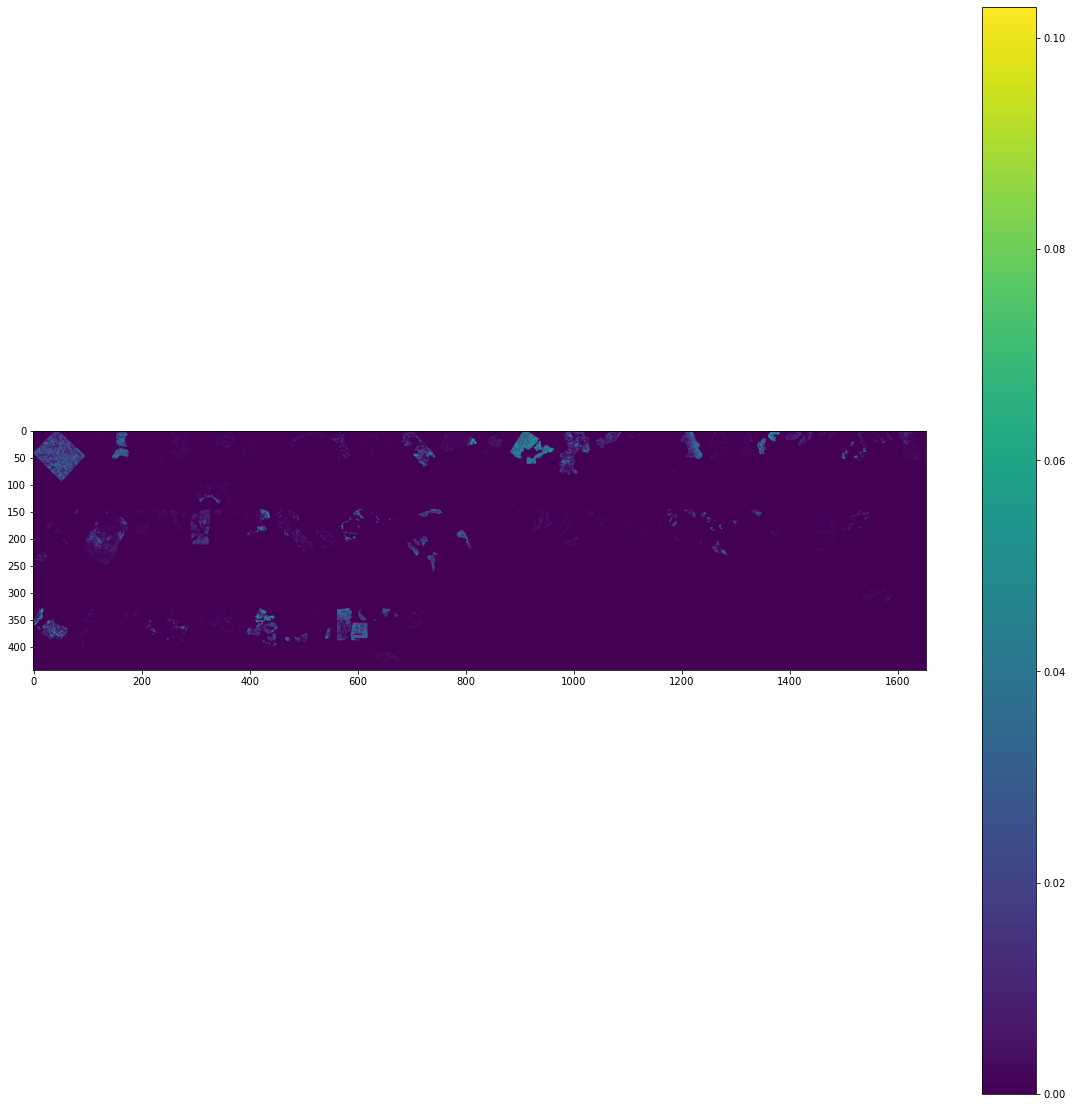

In [25]:
plt.figure(figsize = (20, 20))
plt.imshow(P4)
plt.colorbar()

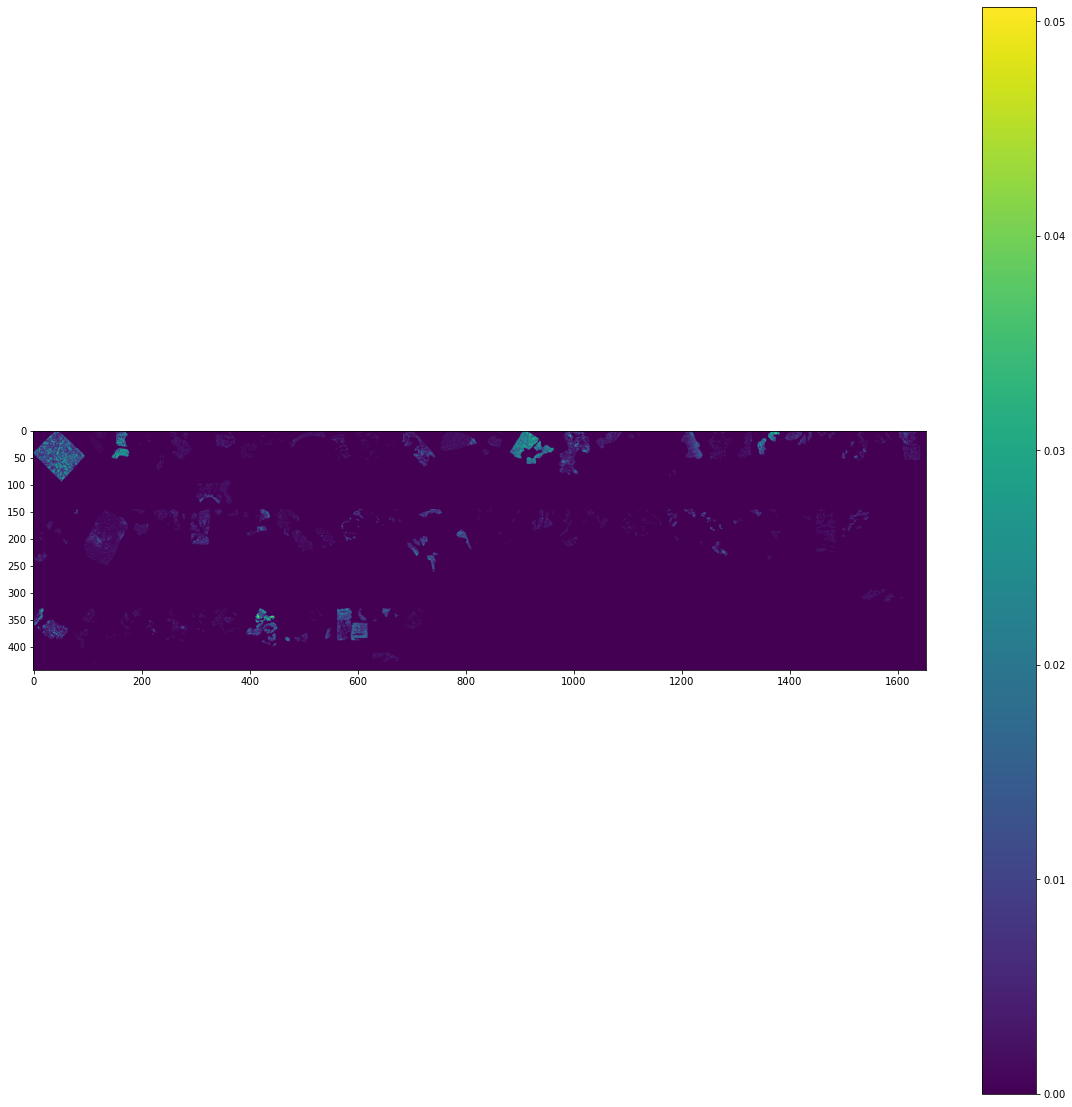

In [26]:
plt.figure(figsize = (20, 20))
plt.imshow(P5)
plt.colorbar()

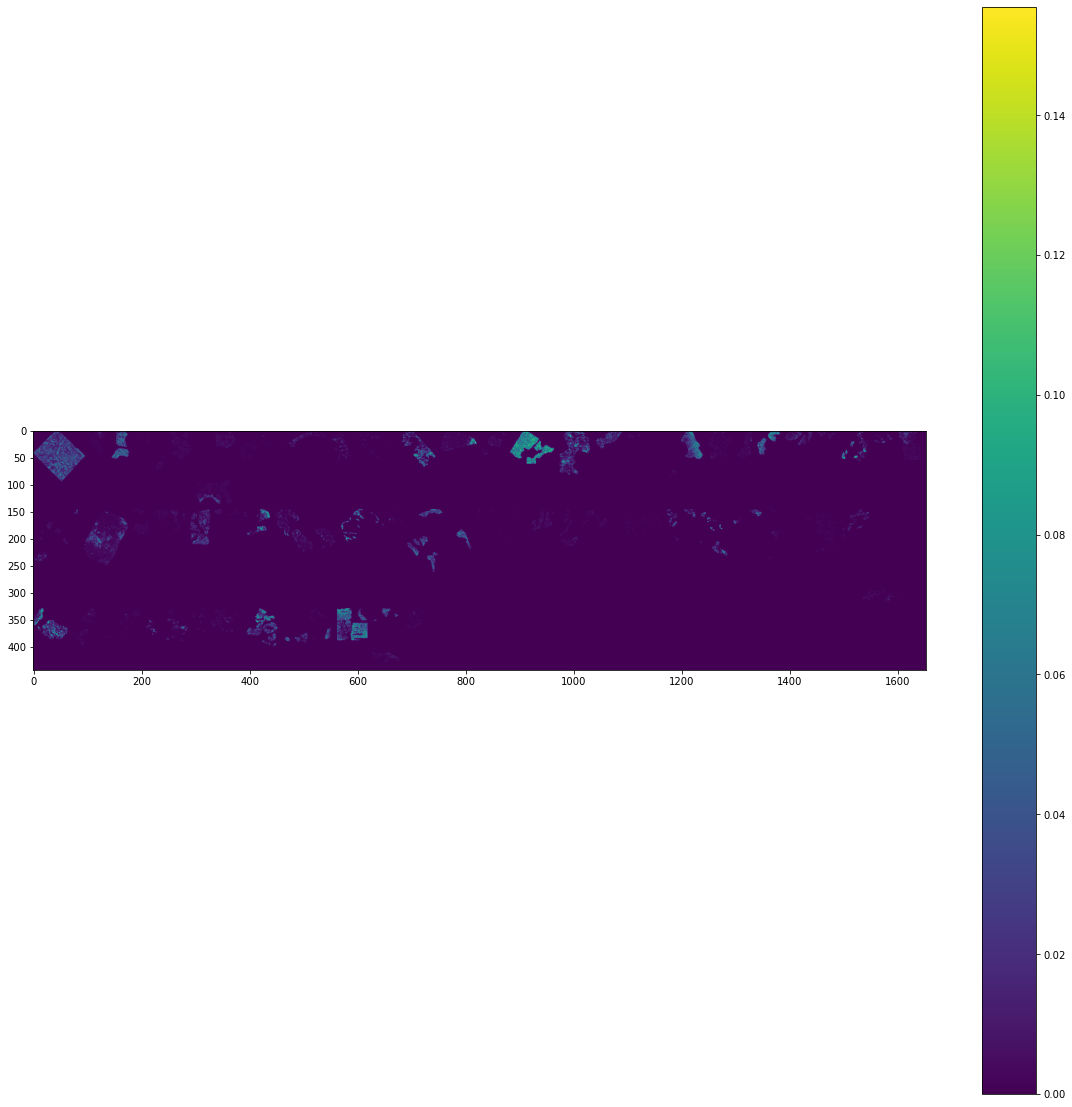

In [27]:
plt.figure(figsize = (20, 20))
plt.imshow(P6)
plt.colorbar()

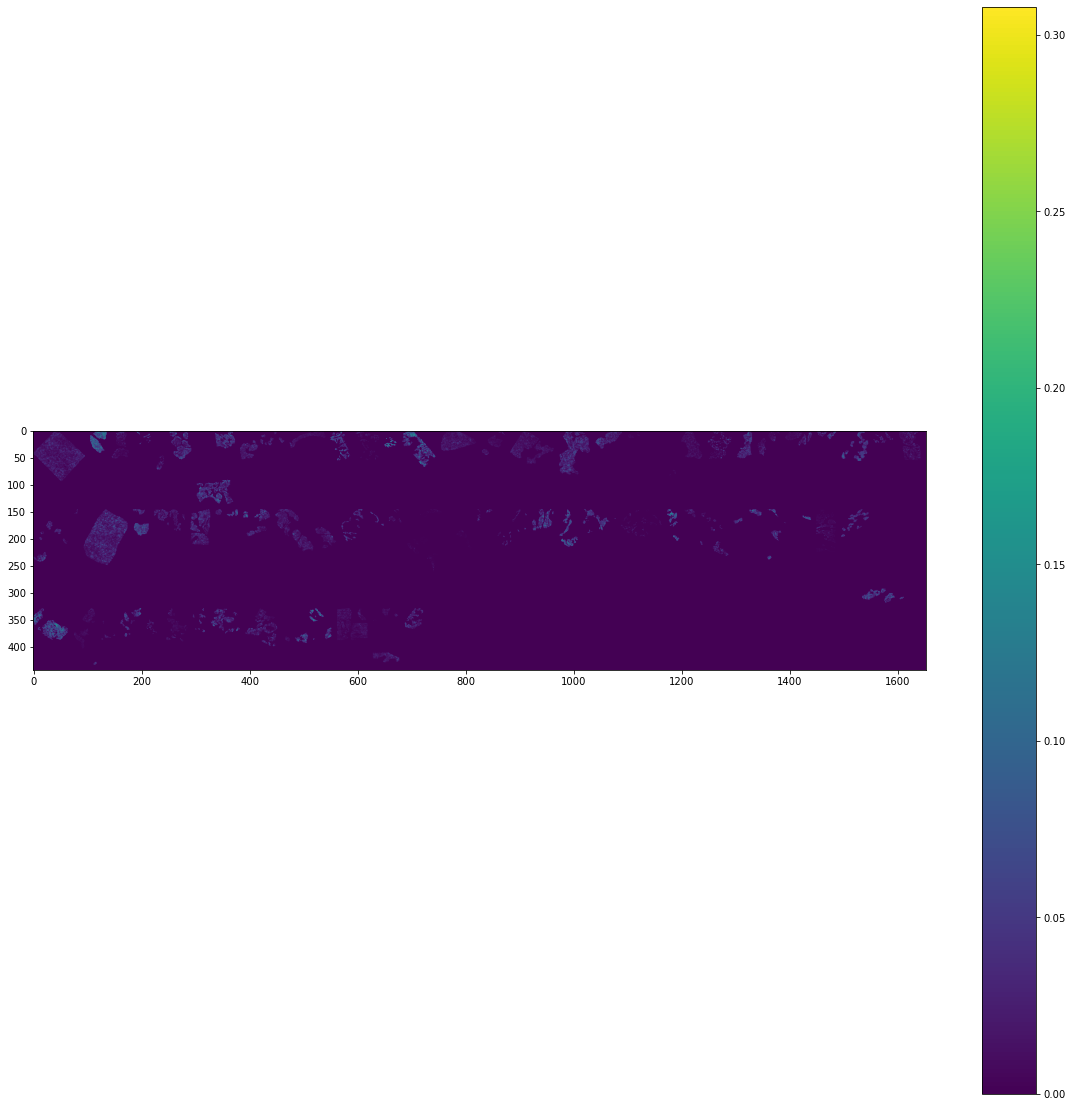

In [28]:
plt.figure(figsize = (20, 20))
plt.imshow(P23)
plt.colorbar()

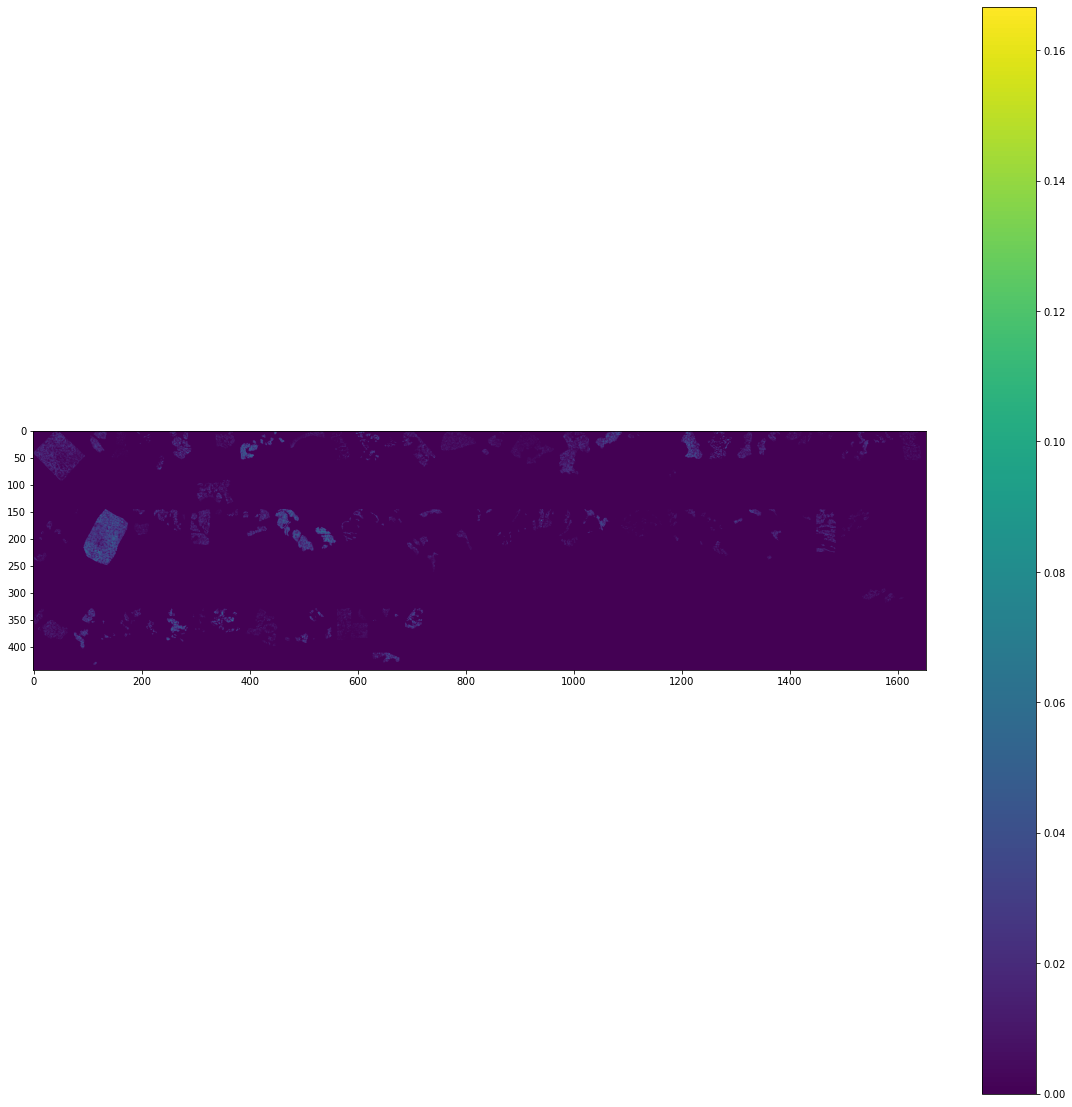

In [29]:
plt.figure(figsize = (20, 20))
plt.imshow(P74)
plt.colorbar()

## Visualization of protein_10 from MSI_data_cube

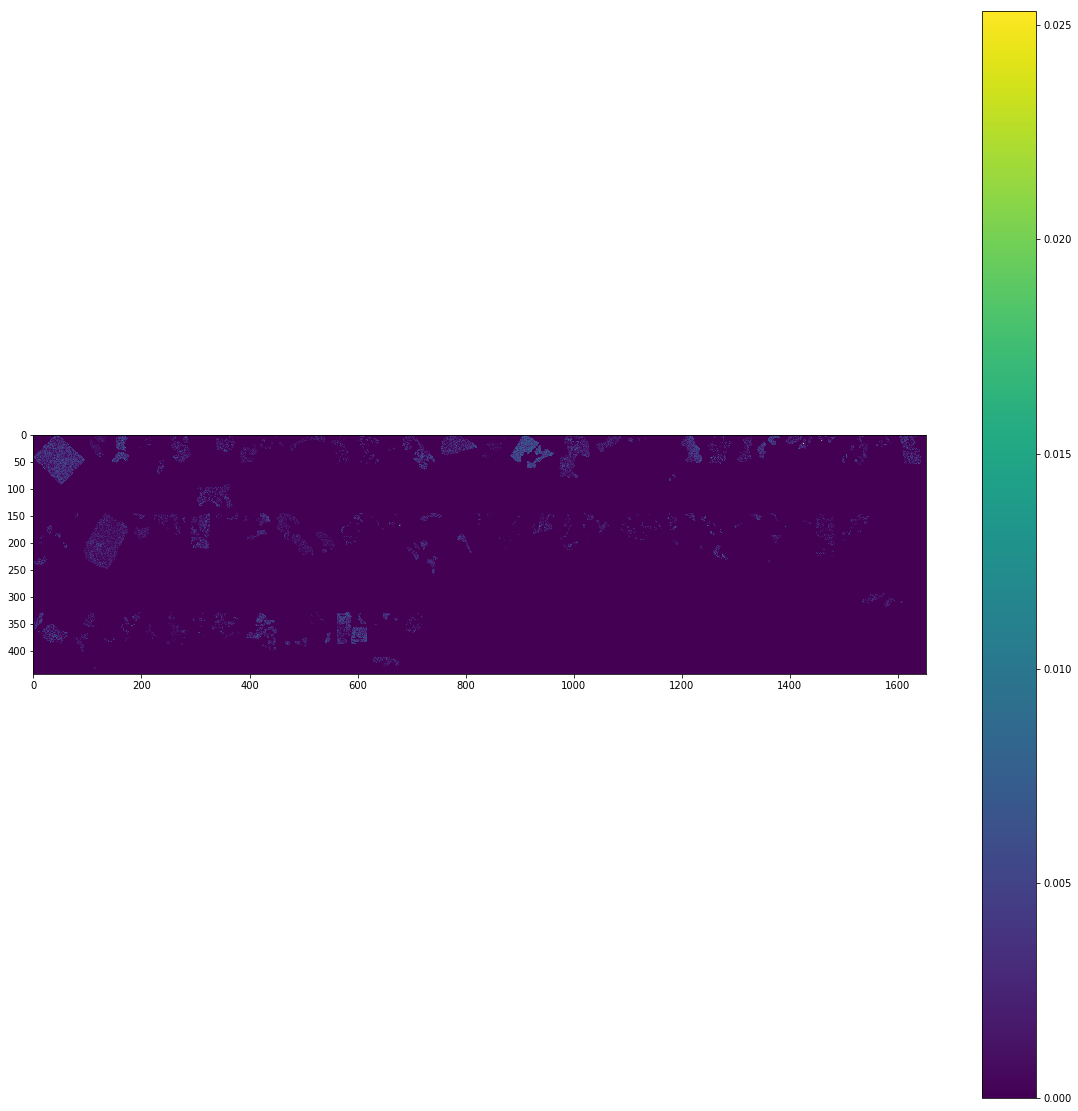

In [18]:
p_10 = MSI[:,:,10]
plt.figure(figsize=(20,20))
plt.imshow(p_10)
plt.colorbar()

## Selecting one pixel from MSI data

In [30]:
spectra = MSI[20, 50, :]
print("Spectra shape is:", spectra.shape)
print("m/z values shape is:", mz_val.shape)

Spectra shape is: (82,)
m/z values shape is: (82,)


In [32]:
max(spectra)

0.042613354949233226

## Spectrum with m/z value of one pixel 

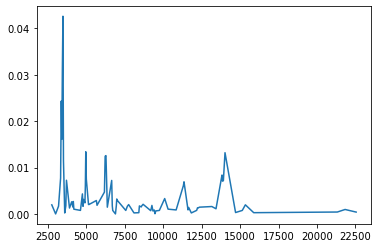

In [33]:
plt.plot(mz_val, np.squeeze(spectra))

In [5]:
data['y']

array([[443]], dtype=uint16)

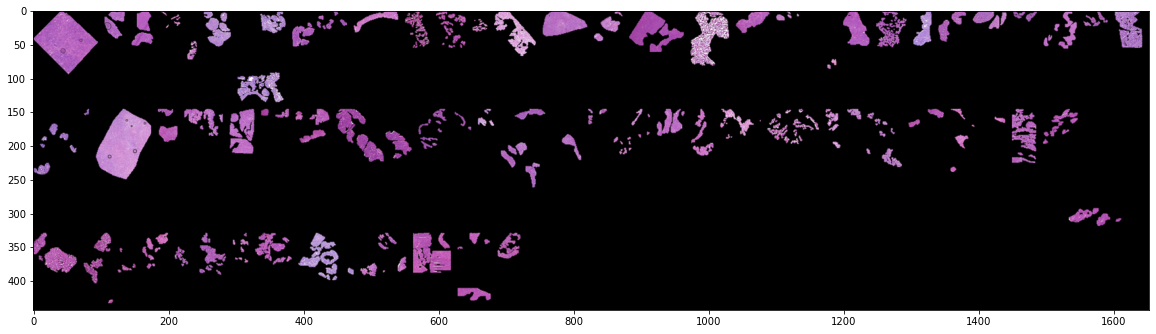

In [35]:
plt.figure(figsize=(20, 20))
plt.imshow(gc_data['HE_image'])

(array([1983086.,    8816.,   16474.,   31998.,   25502.,   15649.,
          29574.,   55919.,   27176.,    2643.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

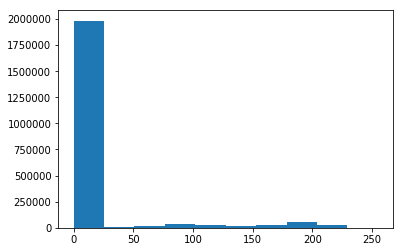

In [48]:
plt.hist(data['HE_image'].ravel())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


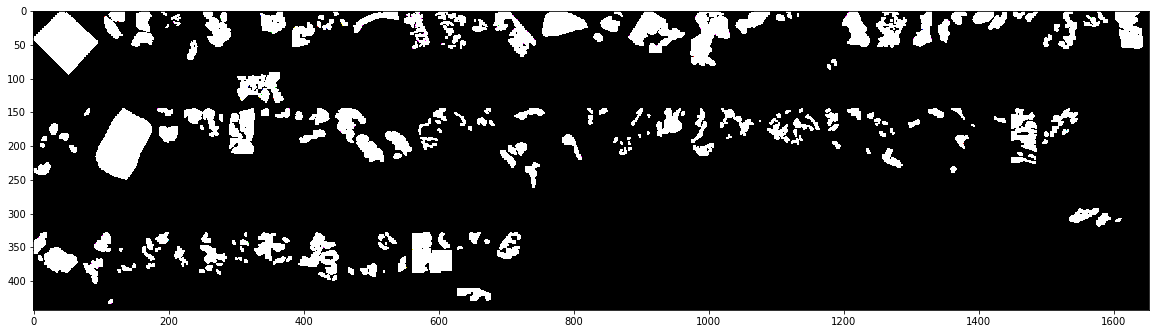

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(data['HE_image'] * mz_val[0])

In [8]:
len(data['HE_image'])

443

In [9]:
data['HE_image'].size

2196837

In [10]:
data['HE_image'].shape

(443, 1653, 3)

In [48]:
test = data['HE_image'][4]
print(type(test))
print(test)

# array = np.array([[1,2,3],
#         [5,3,4],
#         [6,7,2.]])

# print(array/array.sum(1, keepdims=True))

<class 'numpy.ndarray'>
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


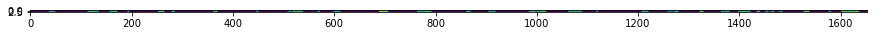

In [53]:
plt.figure(figsize=(15, 15))
plt.imshow(data['HE_i'])

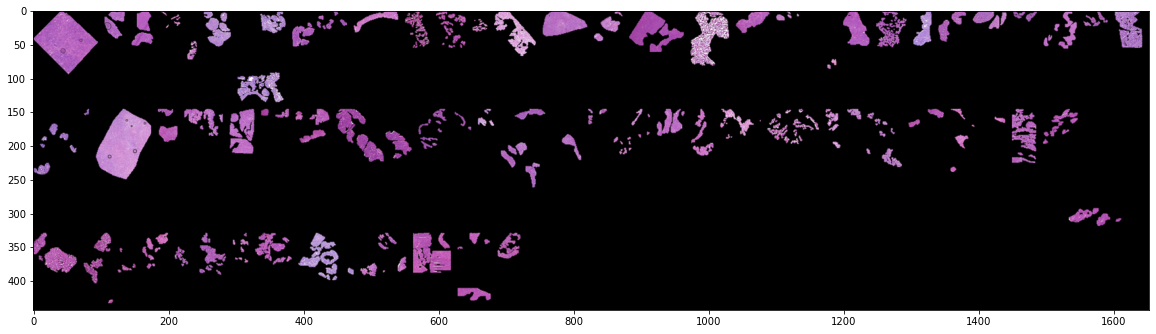

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(data['HE_image'])

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [18]:
tsne = TSNE()
X_tsne = tsne.fit_transform(data['HE_image'][0])

In [36]:
tsne = TSNE()

In [19]:
nsamples, nx, ny = data['HE_image'].shape
d2_train_dataset = data['HE_image'].reshape((nsamples,nx*ny))

In [20]:
X_tsne = tsne.fit_transform(d2_train_dataset)

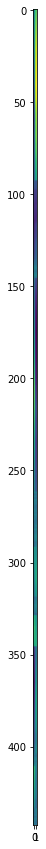

In [21]:
plt.figure(figsize=(15, 15))
plt.imshow(X_tsne)

In [10]:
data['None'][0][3]

array([[3707764736],
       [         2],
       [         1],
       [         1],
       [         1],
       [         1]], dtype=uint32)

In [12]:
data['None'][0][0]

b'Clinical_data'

In [9]:
data['None'][0][1]

b'MCOS'

In [10]:
data['None'][0][2]

b'dataset'

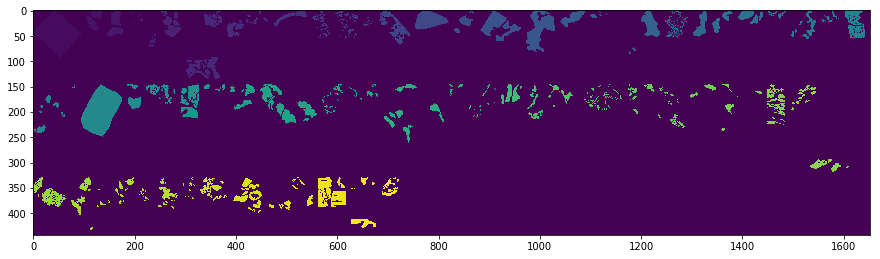

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(data['pixel_to_sample_ID'])

In [26]:
data['peak_list']

array([[2.75700000e+03, 1.76690867e+01, 2.75314020e+03, 2.76085980e+03],
       [3.00600000e+03, 1.47126952e+01, 3.00179160e+03, 3.01020840e+03],
       [3.19600000e+03, 2.17044555e+01, 3.19152560e+03, 3.20047440e+03],
       [3.33000000e+03, 6.48135994e+01, 3.32533800e+03, 3.33466200e+03],
       [3.37400000e+03, 1.96713385e+02, 3.36927640e+03, 3.37872360e+03],
       [3.40900000e+03, 8.74490767e+01, 3.40422740e+03, 3.41377260e+03],
       [3.44500000e+03, 3.05325220e+02, 3.44017700e+03, 3.44982300e+03],
       [3.48200000e+03, 2.20805023e+02, 3.47712520e+03, 3.48687480e+03],
       [3.51600000e+03, 7.37939734e+01, 3.51107760e+03, 3.52092240e+03],
       [3.59800000e+03, 1.15625975e+01, 3.59296280e+03, 3.60303720e+03],
       [3.67000000e+03, 1.36473829e+01, 3.66486200e+03, 3.67513800e+03],
       [3.71100000e+03, 3.74803408e+01, 3.70580460e+03, 3.71619540e+03],
       [3.90800000e+03, 2.38455072e+01, 3.90252880e+03, 3.91347120e+03],
       [4.05100000e+03, 1.16956934e+01, 4.04532860e

In [29]:
data['MSI_data_cube']

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [34]:
clinical_data = pd.read_csv('clinical_data.csv')
clinical_data.head(20)

,Sample_ID,T,N,M,Surv_time,Surv_status
0,1,2,0,x,1027,0
1,2,2,0,x,20,1
2,3,2,0,x,13,0
3,4,2,0,x,1350,0
4,5,2,0,x,1006,1
5,6,2,0,x,1415,0
6,7,2,0,x,47,0
7,8,2,0,x,791,0
8,9,2,0,x,1341,0
9,10,2,0,x,1558,0
